### Librerias

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
import random

In [28]:
archivo_excel = 'C:/Users/Usuario/Downloads/proyecto final/completo.xlsx'

# Cargar el archivo en un DataFrame
df = pd.read_excel(archivo_excel, engine='openpyxl')
df.head()

,Nº,Repetición|Ajuste,Cliente,Ctd,Servicio,Sector,Etapa,Empleado,Início,Finalizado,Fecha entrada,Fecha prevista,Tiempo Horas,Trabajo retrasado
0,0051,-,PEDRO MORALES,10,Encia Acrilica,ACRILICO,RESINA,NORMA JUNCAL,2024-01-22 16:05:00,2024-01-22 16:05:00,31/08/2023 12:12,2023-11-08,00:01,Si
1,0085,-,ALAN SULIKOWSKI,20,Provisorio de PMMA Cad Cam,FRESADO,PMMA,LUCIANO TORIANI,2024-03-08 11:32:00,2024-03-11 10:46:00,23/10/2023 13:50,2024-03-08,71:15,Si
2,0085,-,ALAN SULIKOWSKI,20,Provisorio de PMMA Cad Cam,ACRILICO,TERMINACION,DEMIAN SANTOS,2024-03-07 14:38:00,2024-03-08 09:02:00,23/10/2023 13:50,2024-03-08,18:24,Si
3,0085,-,ALAN SULIKOWSKI,20,Provisorio de PMMA Cad Cam,DISEÑO,CORONAS,DEMIAN SANTOS,2024-03-07 14:37:00,2024-03-07 14:37:00,23/10/2023 13:50,2024-03-08,00:01,Si
4,0099,-,SANTIAGO BRAVERMAN,6,Diseño 3D por Pieza,DISEÑO,DISEÑO DE SONRISA,LUCAS RODRIGUEZ,2024-03-04 12:43:00,2024-03-04 12:43:00,25/10/2023 14:03,2024-03-05,00:01,No


### EDA basico

Nº                   0.000000
Repetición|Ajuste    0.000000
Cliente              0.000000
Ctd                  0.000000
Servicio             0.000000
Sector               0.000000
Etapa                0.000000
Empleado             4.510801
Início               4.517860
Finalizado           4.962586
Fecha entrada        0.000000
dtype: float64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12668\3797597487.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Percentage Missing', data=missing_cols, palette='Blues_d')


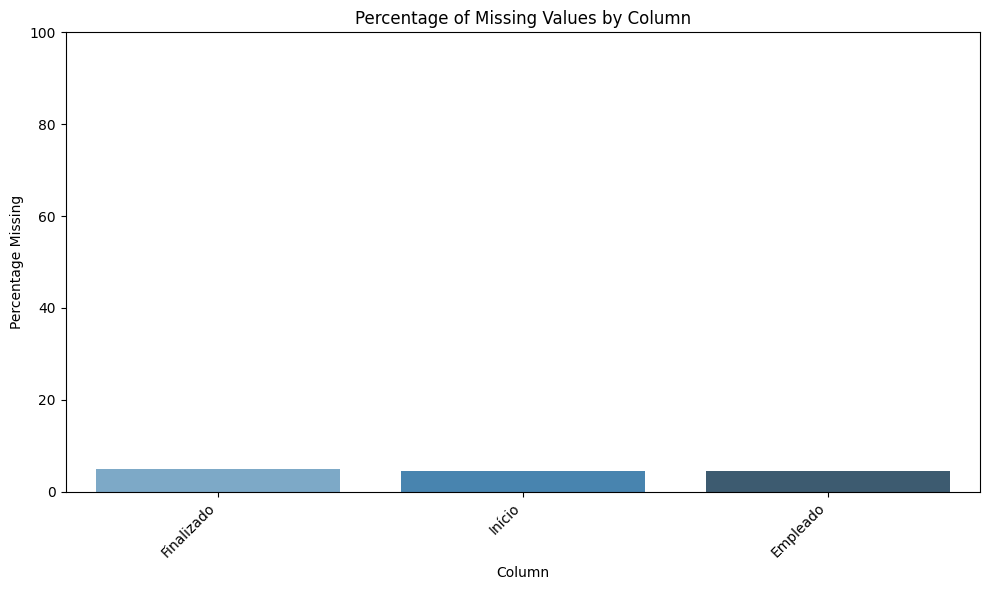

In [23]:
## Missings 

# 1. Calcular el porcentaje de valores faltantes por columna
missing_percentages = df.isnull().mean() * 100
print(missing_percentages)

# 2. Filtrar las columnas con valores faltantes
missing_cols = missing_percentages[missing_percentages > 0].sort_values(ascending=False).to_frame().reset_index()
missing_cols.columns = ['Column', 'Percentage Missing']

# 3. Graficar los porcentajes de valores faltantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='Percentage Missing', data=missing_cols, palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.xlabel("Column")
plt.ylabel("Percentage Missing")
plt.title("Percentage of Missing Values by Column")
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Hopkins statistic = 1.0


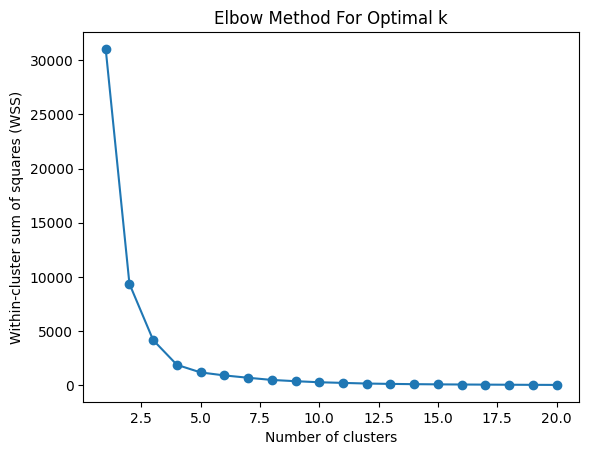

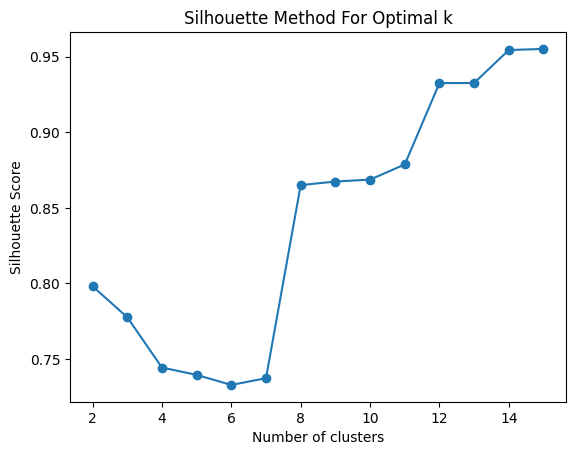

No hay suficientes columnas numéricas para crear un scatter plot.


In [12]:
## Clustering

cols = ["Ctd"]
df_c = df[cols]

# 2. Escalar las columnas numéricas con medianas y IQR
def rob_scale(x):
    if np.issubdtype(x.dtype, np.number):
        return (x - np.nanmedian(x)) / iqr(x, nan_policy='omit')
    else:
        return x

df_c_scaled = df_c.apply(rob_scale)

# 3. Eliminar filas con NaN
df_c_scaled = df_c_scaled.dropna()

# 4. Eliminar columnas constantes
constant_cols = df_c_scaled.apply(lambda x: len(x.unique()) == 1)
df_c_scaled = df_c_scaled.loc[:, ~constant_cols]

# 5. Eliminar columnas con varianza baja
variance_threshold = 0.01
df_c_scaled = df_c_scaled.loc[:, df_c_scaled.var() > variance_threshold]

# 6. Realizar el test de Hopkins
def hopkins_stat(data, n):
    d = data.values
    nbrs = NearestNeighbors(n_neighbors=1).fit(d)
    
    random_points = np.random.uniform(np.min(d, axis=0), np.max(d, axis=0), (n, d.shape[1]))
    u_distances, _ = nbrs.kneighbors(random_points, return_distance=True)
    w_distances, _ = nbrs.kneighbors(d[np.random.choice(d.shape[0], n, replace=False)], return_distance=True)
    
    hopkins_stat = u_distances.sum() / (u_distances.sum() + w_distances.sum())
    return hopkins_stat

hopkins = hopkins_stat(df_c_scaled, 35)
print(f"Hopkins statistic = {hopkins}")

# 7. Elbow method (determinación del número óptimo de clusters)
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cityblock

def elbow_method(data, k_max=20):
    wss = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, n_init=50)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)
    plt.plot(range(1, k_max+1), wss, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-cluster sum of squares (WSS)')
    plt.title('Elbow Method For Optimal k')
    plt.show()

elbow_method(df_c_scaled)

# 8. Silhouette method
def silhouette_method(data, k_max=15):
    silhouette_scores = []
    for k in range(2, k_max+1):
        kmeans = KMeans(n_clusters=k, n_init=50)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_, metric="manhattan")
        silhouette_scores.append(score)
    plt.plot(range(2, k_max+1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

silhouette_method(df_c_scaled)

# 9. K-means clustering (con k=3)
km = KMeans(n_clusters=3, n_init=50)
df_c_scaled['cluster'] = km.fit_predict(df_c_scaled)

# 10. Graficar scatter plot por cluster
def plot_scatter_by_cluster(df, cluster_col):
    # Seleccionar dos columnas numéricas para los ejes x e y (puedes cambiar las columnas según tu interés)
    cols = df.columns[:-1]  # Excluye la columna 'cluster'
    if len(cols) < 2:
        print("No hay suficientes columnas numéricas para crear un scatter plot.")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Crear scatter plot con las dos primeras columnas seleccionadas
    sns.scatterplot(
        x=df[cols[0]], 
        y=df[cols[1]], 
        hue=df[cluster_col], 
        palette='viridis',  # Cambia la paleta de colores si lo deseas
        alpha=0.7
    )
    
    # Títulos y etiquetas
    plt.title(f"Scatter Plot of {cols[0]} vs {cols[1]} by Cluster")
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend(title='Cluster')
    plt.tight_layout()
    
    # Mostrar gráfico
    plt.show()

# Llamar a la función para graficar
plot_scatter_by_cluster(df_c_scaled, 'cluster')



In [24]:
## Resumen estadistico

print("CANTIDAD DE DIENTES")
print(df["Ctd"].describe())
print("--------------------------")

CANTIDAD DE DIENTES
count    14166.000000
mean         3.526048
std          4.441898
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         46.000000
Name: Ctd, dtype: float64
--------------------------


### Analisis descriptivo

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12668\762451743.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clientes_top5.index, y=clientes_top5.values, palette='Blues_d')


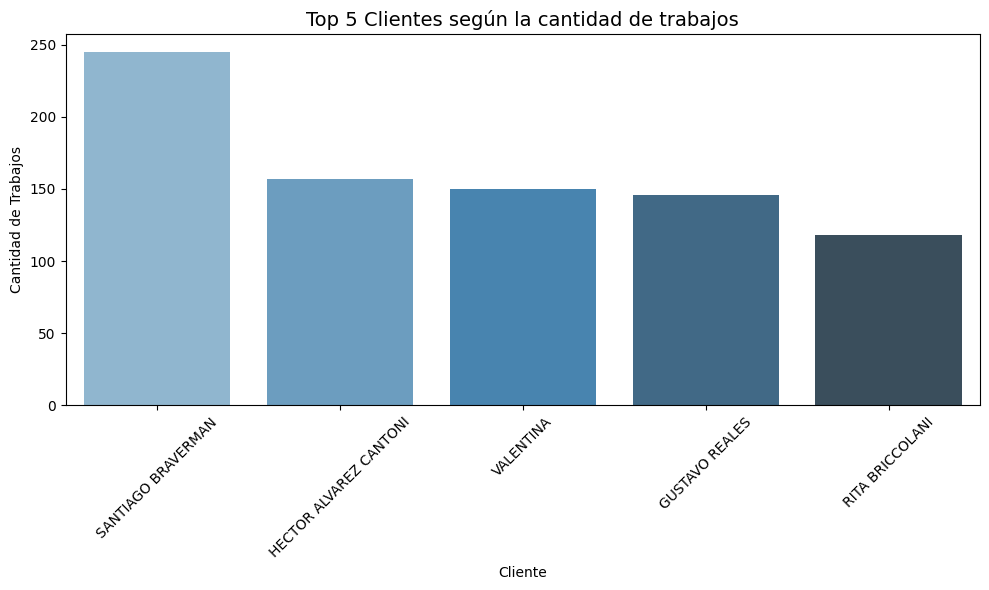

In [27]:
## TOP 5 clientes con más trabajos

# Agrupar por cliente y contar el número de IDs de trabajo únicos
clientes_top5 = df.groupby('Cliente')['Nº'].nunique().nlargest(5)

# Crear un gráfico de barras con los top 5 clientes
plt.figure(figsize=(10, 6))
sns.barplot(x=clientes_top5.index, y=clientes_top5.values, palette='Blues_d')

# Agregar títulos y etiquetas
plt.title("Top 5 Clientes según la cantidad de trabajos", fontsize=14)
plt.xlabel("Cliente")
plt.ylabel("Cantidad de Trabajos")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12668\4005532358.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=odontologos_top5.index, y=odontologos_top5.values, palette='viridis')


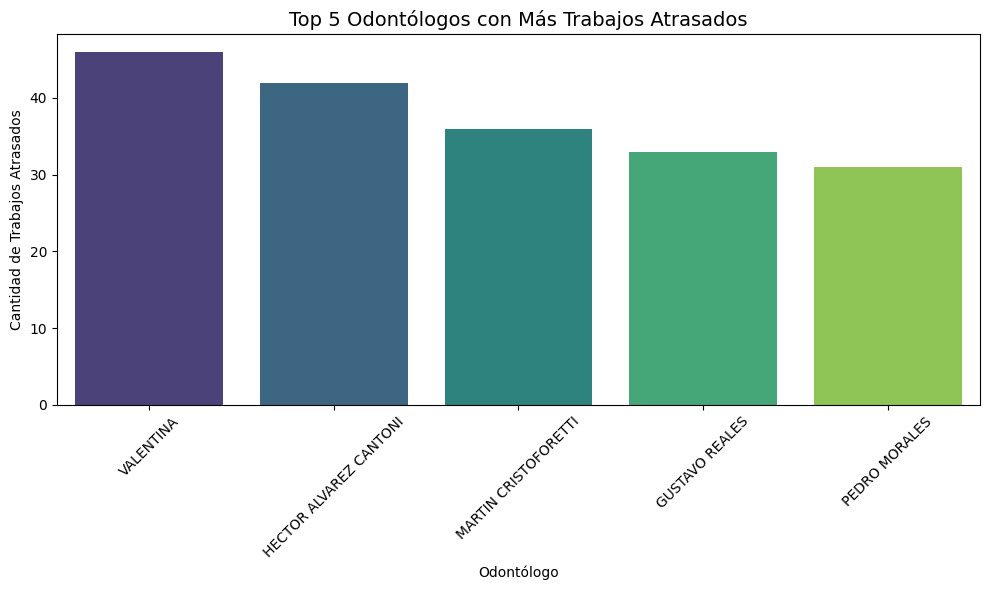

In [29]:
## TOP 5 odontologos con más trabajos atrasados

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'odontologo' es la columna del odontólogo, 'Trabajo retrasado' indica si el trabajo está atrasado,
# y 'id_trabajo' es la columna del ID del trabajo.

# Filtrar los registros donde el trabajo está retrasado
df_atrasado = df[df['Trabajo retrasado'] == 'Si']

# Agrupar por odontólogo y contar el número de trabajos atrasados
odontologos_top5 = df_atrasado.groupby('Cliente')['Nº'].nunique().nlargest(5)

# Crear un gráfico de barras con los top 5 odontólogos
plt.figure(figsize=(10, 6))
sns.barplot(x=odontologos_top5.index, y=odontologos_top5.values, palette='viridis')

# Agregar títulos y etiquetas
plt.title("Top 5 Odontólogos con Más Trabajos Atrasados", fontsize=14)
plt.xlabel("Odontólogo")
plt.ylabel("Cantidad de Trabajos Atrasados")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


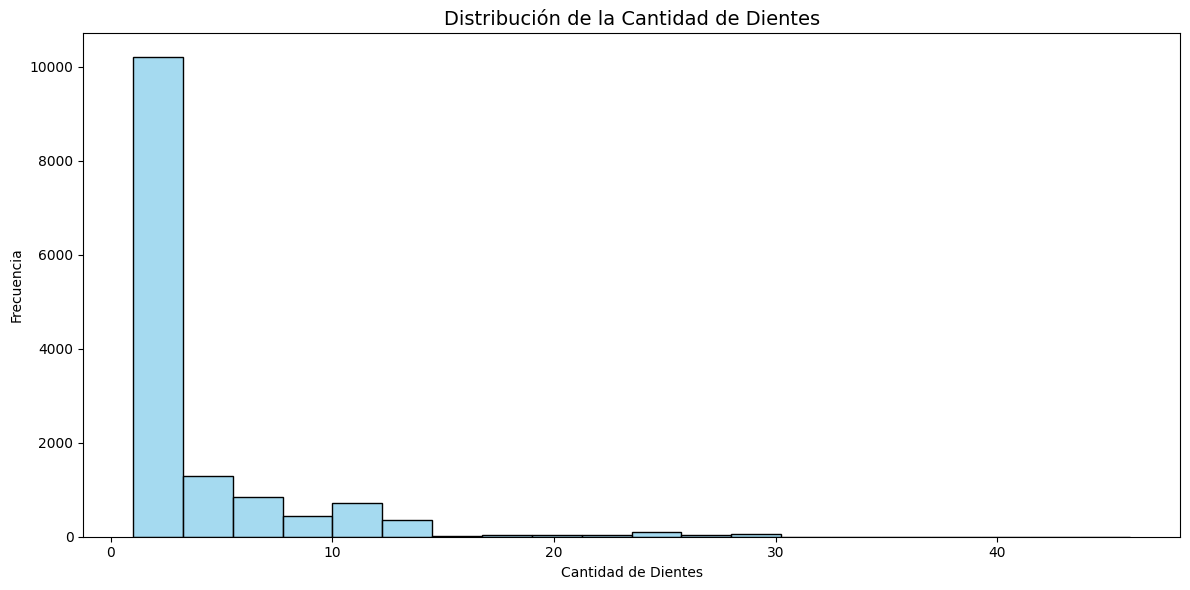

In [33]:
# Cantidad de dientes

# Crear un histograma de la cantidad de dientes
plt.figure(figsize=(12, 6))
sns.histplot(df['Ctd'], bins=20, kde=False, color='skyblue')

# Agregar títulos y etiquetas
plt.title("Distribución de la Cantidad de Dientes", fontsize=14)
plt.xlabel("Cantidad de Dientes")
plt.ylabel("Frecuencia")
plt.tight_layout()

# Mostrar el gráfico
plt.show()



C:\Users\Usuario\AppData\Local\Temp\ipykernel_12668\1289738104.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Trabajo retrasado', y='Ctd', data=df, palette='pastel')


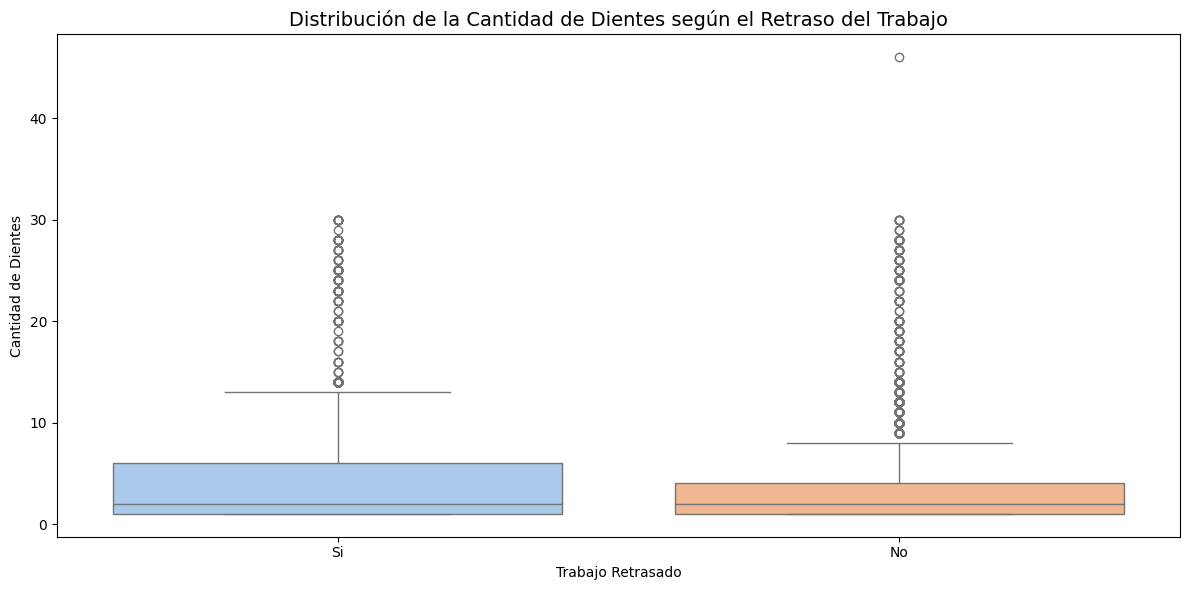

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de cajas para visualizar la distribución de la cantidad de dientes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Trabajo retrasado', y='Ctd', data=df, palette='pastel')

# Agregar títulos y etiquetas
plt.title("Distribución de la Cantidad de Dientes según el Retraso del Trabajo", fontsize=14)
plt.xlabel("Trabajo Retrasado")
plt.ylabel("Cantidad de Dientes")
plt.tight_layout()

# Mostrar el gráfico
plt.show()
